In [1]:
%pylab inline
rc("image", cmap="gray", interpolation="nearest")

Populating the interactive namespace from numpy and matplotlib


In [2]:
# common imports
import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
import sklearn
import torch
from graphviz import Source
from matplotlib import gridspec
from scipy.stats import kde
from sklearn import decomposition
from torch import nn, optim

import imgclass
import imgimg

In [3]:
# helper functions
def plot_density(data, nbins=100):
    x, y = data.T
    k = kde.gaussian_kde(data.T)
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    pcolormesh(xi, yi, zi.reshape(xi.shape),
               shading='gouraud', cmap=plt.cm.BuGn_r)
    contour(xi, yi, zi.reshape(xi.shape))


def tshow(v, ax=None, **keys):
    if isinstance(v, torch.Tensor):
        v = v.cpu().detach().numpy()
    if v.ndim == 1:
        v = v.reshape(28, 28)
    if ax is not None:
        ax.imshow(v, **keys)
    else:
        imshow(v, **keys)


def showgrid(images, rows=4, cols=4, cmap=cm.gray, size=(6, 6)):
    if size is not None:
        figsize(*size)
    for i in range(rows*cols):
        subplot(rows, cols, i+1)
        xticks([])
        yticks([])
        tshow(images[i], cmap=cmap)


def showrow(*args):
    for i, im in enumerate(args):
        subplot(1, len(args), i+1)
        tshow(im)


def T(a):
    return torch.FloatTensor(a).cuda()


def N(a):
    return a.cpu().detach().numpy()


def center_rows(images):
    shape = images.shape
    images = images.reshape(len(images), -1)
    images = images - mean(images, axis=1)[:, newaxis]
    images /= norm(images, axis=1)[:, newaxis]
    images.reshape(*shape)
    return images


def flat_rows(images):
    return images.reshape(len(images), -1)

In [4]:
# load MNIST data
def load_images(images):
    #images = ndi.gaussian_filter(images, (0, 0.5, 0.5))
    images = center_rows(images)
    images = flat_rows(images)
    cuimages = torch.FloatTensor(images).cuda()
    return images, cuimages


db = h5py.File('/mdata/H5DATA/mnist.h5')
images, cuimages = load_images(np.array(db["images"]))
classes = np.array(db["labels"])
cuclasses = torch.LongTensor(classes).cuda()
test_images, cutest_images = load_images(np.array(db["test_images"]))
test_classes = np.array(db["test_labels"])
cutest_classes = torch.LongTensor(test_classes).cuda()
print cuimages.shape

torch.Size([60000, 784])


In [5]:
# display helpers


def display_components(a, l, fs=None, rows=1, row=0, yscale="log", ylim=None):
    fig = plt.figure(figsize=fs)
    outer = gridspec.GridSpec(rows, 2, wspace=0.2, hspace=0.2)
    inner = gridspec.GridSpecFromSubplotSpec(4, 4,
                                             subplot_spec=outer[2*row], wspace=0.1, hspace=0.1)
    for j in range(16):
        ax = plt.Subplot(fig, inner[j])
        image = a[j]
        if isinstance(a, (torch.Tensor, torch.cuda.FloatTensor)):
            a = N(a)
        if image.ndim == 1:
            image = image.reshape(len(image)//28, 28)
        ax.imshow(image, cmap=cm.RdBu)
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

    if l is not None:
        ax = plt.Subplot(fig, outer[2*row+1])
        ax.plot(l)
        ax.set_yscale(yscale)
        if ylim is not None:
            ax.set_ylim(ylim)
        fig.add_subplot(ax)

    if False:
        ax = plt.Subplot(fig, outer[2])
        ax.imshow(dot(a, a.T))
        fig.add_subplot(ax)


def plot_pca_variance(data, k, **kw):
    pca = decomposition.PCA(k)
    pca.fit(data.reshape(len(data), -1))
    plot(pca.explained_variance_, **kw)

# Introduction

![chapter](chapter.png)

In this section, we are going to look at the relationship between linear methods, linear subspaces, and deep learning.

This is complementary to recent methods of analyzing neural networks like...
- deep dreaming
- layer reconstruction
- "manifold"-based arguments

Why?
- the linear theory is the basis for the non-linear theory ("manifolds")
- the linear theory is well-developed (independence, optimal coding, etc.)
- we can find optimal solutions to various problems (e.g., linear reconstructions)
- you should know the linear theory
- these are practical, deterministic tools for analyzing neural network layers

# Simple PCA

![chapter](chapter.png)

## PCA

Principal Component Analysis solves the following problem:
    
Find a matrix $W \in \mathbb{R}^{k\times n}$ that is orthonormal $ W W^T = \mathbb{1} $ that
minimize reconstruction error 

$$ \sum || W^T W x_i - x_i || ^ 2 $$

I.e., represent some collection of vectors in an optimal way in a subspace.

In [6]:
# compute a PCA and display the components

def show_pca(data, n_pca=100, **kw):
    pca = decomposition.PCA(n_pca)
    pca.fit(data.reshape(len(data), -1))
    display_components(pca.components_, pca.explained_variance_, **kw)
    return pca

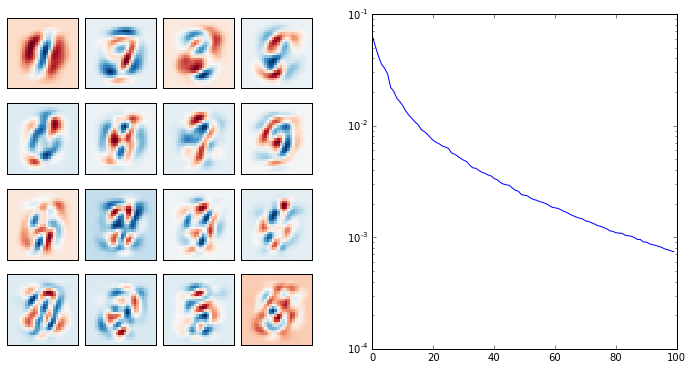

In [7]:
# PCA - learn to recognize these shapes
pca = show_pca(images, 100, fs=(12,6))

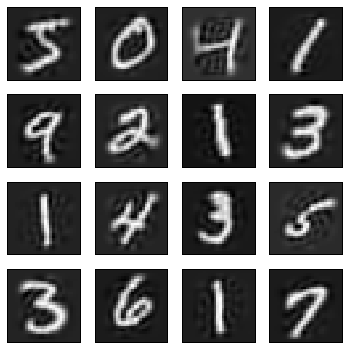

In [8]:
# project onto the transform's subspace then project back

def tproject(f, inputs):
    return f.inverse_transform(f.transform(inputs))

showgrid(tproject(pca, images))

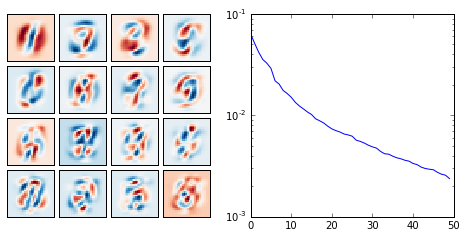

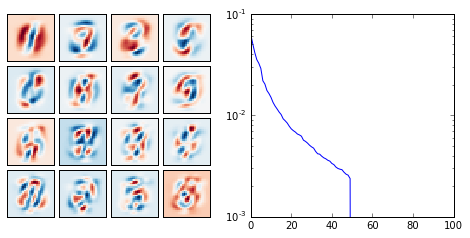

In [9]:
# after a first PCA, the components are "just gone" in a second PCA

figsize(8,8)
pca = show_pca(images, 50, rows=2, row=0, ylim=(1e-3, 1e-1))
pca2 = show_pca(tproject(pca, images), 100, rows=2, row=1, ylim=(1e-3, 1e-1))

![summary](sicon.png)

PCA finds an optimal (L2 sense) linear subspace for representing the input.

PCA consists of a rotation, a projection, and a measure of variances in each direction.

When data exists in a linear subspace, the variances drop to zero.

# ICA Subspaces

![chapter](chapter.png)

## Independent Component Analysis
    
Find a matrix $W \in \mathbb{R}^{k\times n}$ that is orthonormal $ W W^T = \mathbb{1} $ that
minimize reconstruction error 

- the components of $W\cdot x$ have minimal mutual information
- the components of $W\cdot x$ are maximally non-Gaussian
- that minimizes $\sum || W\cdot x ||_1$

/opt/conda/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


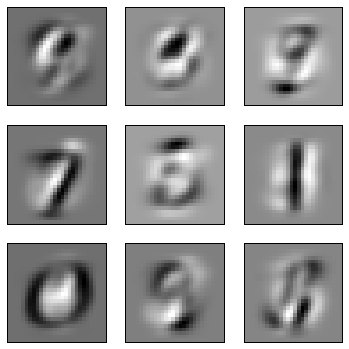

In [10]:
k = 9
ica0 = decomposition.FastICA(k)
ica0.fit(images.reshape(len(images), -1))
ica0_basis = ica0.inverse_transform(diag(ones(k))).reshape(k, 28, 28)
showgrid(ica0_basis, 3, 3)

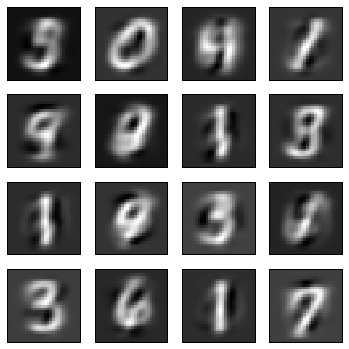

In [11]:
ica0_recon = tproject(ica0, images)
showgrid(ica0_recon)

PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

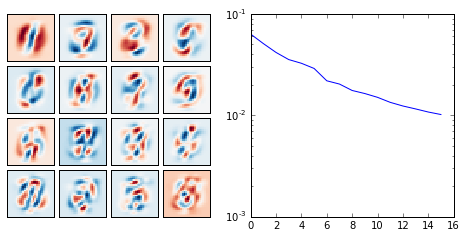

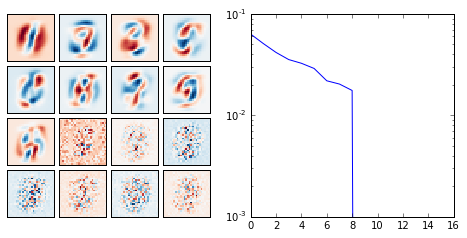

In [12]:
figsize(8,8)
show_pca(images, 16, rows=2, row=0, ylim=(1e-3, 1e-1))
show_pca(ica0_recon, 16, rows=2, row=1, ylim=(1e-3, 1e-1))

![summary](sicon.png)

ICA finds another low-dimensional subspace, with maximum non-Gaussian components.

The ICA space is still a low-dimensional linear subspace, which shows up in PCA analysis.

# The Cocktail Party Problem
![chapter](chapter.png)


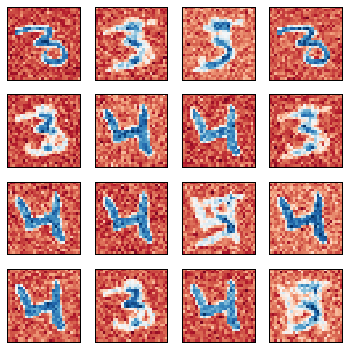

In [48]:
k = 4
mps = (rand(50000, k) < 0.5) + 0.01
mps = mps / mps.sum(1)[:, newaxis]
mixture = dot(mps, images[:10*k:10])
mixture = mixture + 0.01 * randn(*mixture.shape)
mixture = center_rows(mixture)
showgrid(mixture, cmap=cm.RdBu)

PCA finds the optimal representation in terms of reconstruction error.

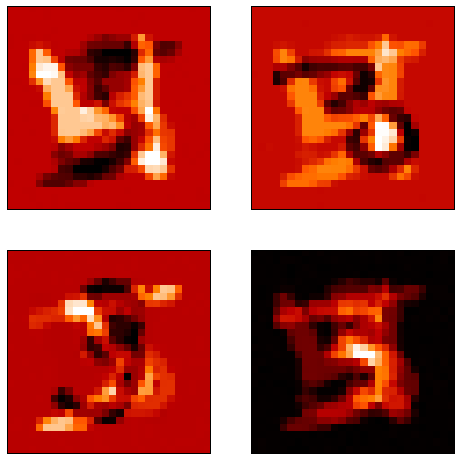

In [50]:
pca = decomposition.PCA(k)
pca.fit(mixture)
for i in range(4):
    if median(pca.components_[i])>0:
        pca.components_[i] = - pca.components_[i]
showgrid(pca.components_, cmap=cm.gist_heat, size=(8,8), rows=2, cols=2)

ICA recovers the independent components instead.

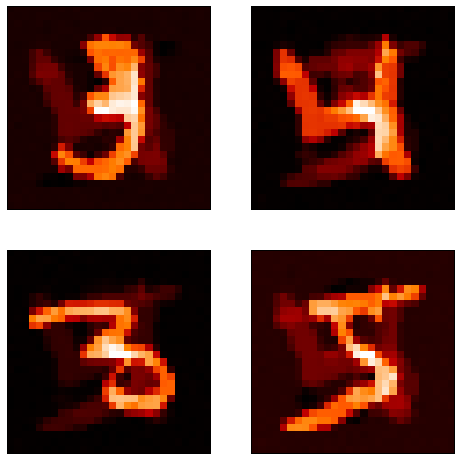

In [51]:
ica = decomposition.FastICA(k)
ica.fit(mixture)
for i in range(4):
    if median(ica.components_[i])>0:
        ica.components_[i] = - ica.components_[i]
showgrid(ica.components_, cmap=cm.gist_heat, size=(8,8), rows=2, cols=2)

![summary](sicon.png)

ICA can separate "mixed sources".

Equivalently, here, each image component has a non-Gaussian (specifically, binomial) distribution.

This can be an important factor in explaining low level feature extraction in images.

# Reconstruction ICA

![chapter](chapter.png)


# Reconstruction ICA (RICA) Definition

ICA is an odd data transformation because it doesn't make reference to actually preserving any of the data. We can come up with an alternative definition based on _reconstruction loss_:

$ \hat{W} = \arg\min_w \lambda ||W X||_1 + || W^T W x - x ||^2_2 $

We may still constraint $ W^T W = \mathbb{1} $.

- For $\lambda \rightarrow \infty$ and whitened data, this is equivalent to ICA.
- For $\lambda = 0$, this is simply PCA or a linear autoencoder.

This can be implemented directly as a neural network.

In [ ]:
def orthocost(a):
    return ((torch.mm(a, a.transpose(1, 0))-torch.eye(a.size(0)).cuda())**2).sum()

def l1cost(y):
    return (y.abs().sum(1)-1).abs().sum()

In [ ]:
class RICA(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.weight = nn.Parameter(1e-4 * torch.rand(50, 28*28))
    def forward(self, x):
        y = self.weight.mm(x.transpose(1,0))
        z = self.weight.transpose(1,0).mm(y).transpose(1, 0)
        cost = 0
        cost = cost + 1e-5 * l1cost(y)
        #cost = cost + 1e-5 * orthocost(self.weight)
        return z, cost
    
def make_model():
    return RICA().cuda()

In [ ]:
amlp = imgimg.AutoMLP(make_model, Tim(images), Tim(images), initial_bs=100, maxtrain=1000000)
rica = amlp.train()

In [ ]:
showgrid(rica.weight, cmap=cm.RdBu)

In [ ]:
imshow(N(rica.weight.mm(rica.weight.transpose(1, 0))))

![summary](sicon.png)

ICA can be formulated as a "neural learning algorithm" similar to PCA as "RICA"

The loss function in RICA is a combination of reconstruction loss (as in PCA) and an L1 loss on the activation of the encoding.

RICA can smoothly interpolate between optimal reconstruction (PCA) and independent components (ICA).

# Analyzing Hidden Layers

![chapter](chapter.png)

In [13]:
def make_model():
    return nn.Sequential(nn.Linear(28*28, 100),
                         nn.Sigmoid(),
                         nn.Linear(100, 10))

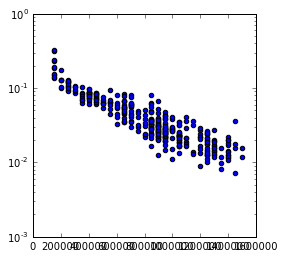

#best 0.0203 @ 1250000 of 1450000


KeyboardInterrupt: 

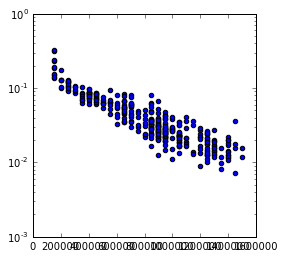

In [14]:
amlp = imgclass.AutoMLP(make_model, cuimages, cuclasses, cutest_images, cutest_classes,
                        initial_bs=20, maxtrain=1000000)
nn100 = amlp.train()
nn100.cuda()

In [15]:
nn100 = amlp.best_model

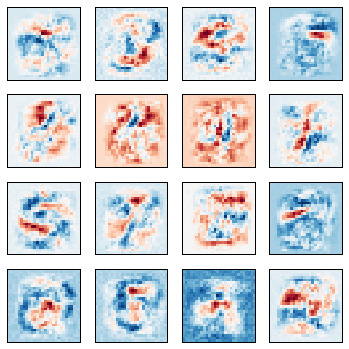

In [16]:
W = N(nn100[0].weight)
showgrid(W, cmap=cm.RdBu)

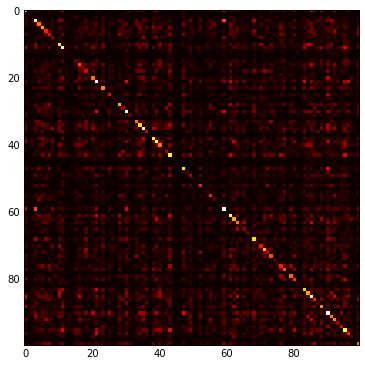

In [17]:
imshow(abs(dot(W, W.T)), cmap=cm.hot)

![summary](sicon.png)

Input units tend towards being imperfectly orthonormal (up to a scale factor).

To the degree that input layers approximate a PCA, the vectors are mixed.

# Output of the First Linear Layer

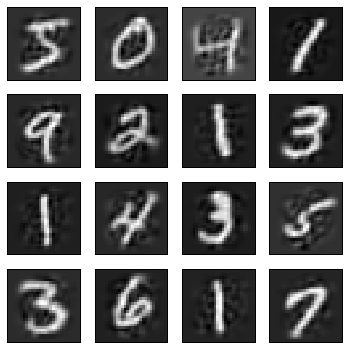

In [18]:
# run data through the first linear layer
nn100first_layer = N(nn100[0](cuimages))

# reconstruct the original images by mapping the linear output back to the input images
nn100recon = dot(nn100first_layer, dot(pinv(nn100first_layer), images))

showgrid(nn100recon)

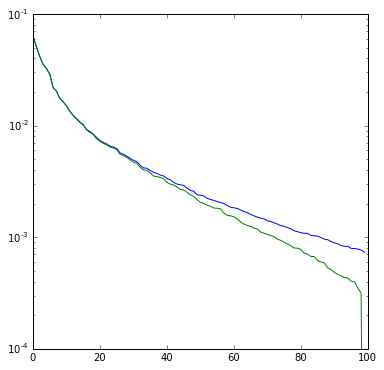

In [19]:
yscale("log")
ylim((1e-4, 1e-1))
plot_pca_variance(images, 100)
plot_pca_variance(nn100recon, 100)

![summary](sicon.png)

We can use the pseudo-inverse to reconstruct inputs from hidden layer outputs.

The generalization of this approach is to try to invert hidden layers by training another neural network.

Inputs are easily reconstructible from the output of the first linear layer.

Most of the variance is accounted for in the output of the linear layer.

# Output of the First Nonlinear Layer

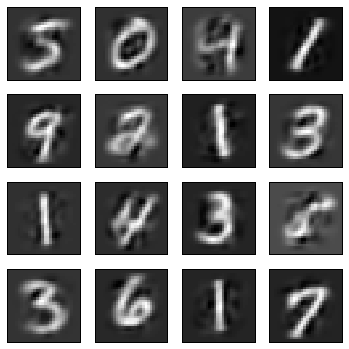

In [20]:
nn100lin = N(nn100[0](cuimages))
nn100nonlin = N(nn.Sequential(nn100[:2])(cuimages))
nn100recon2 = dot(nn100nonlin, dot(pinv(nn100nonlin), images))
showgrid(nn100recon2)

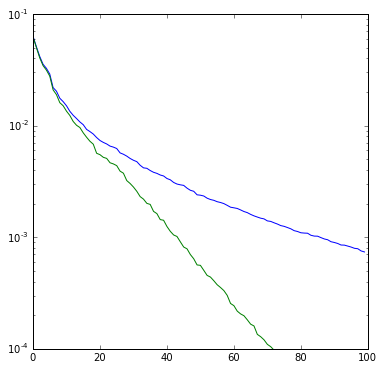

In [21]:
yscale("log"); ylim((1e-4, 1e-1))
plot_pca_variance(images, 100)
plot_pca_variance(nn100recon2, 100)

![summary](sicon.png)

Information loss happens in the non-linear layer.

# Non-Gaussianity via Kurtosis

Can we decide whether input layers are performing PCA or ICA?

In [28]:
pca = decomposition.PCA(100)
pca.fit(images.reshape(len(images), -1))
ica = decomposition.FastICA(100)
ica.fit(images.reshape(len(images), -1))
ica_basis = ica.inverse_transform(diag(ones(100))).reshape(100, 28, 28)

In [29]:
# measures of non-Gaussianity: higher order moments

def skew(v):
    return sqrt(len(v)) * sum((v-mean(v))**3) / sum((v-mean(v))**2)**1.5

def excess_kurtosis(v): 
    return len(v) * sum((v-mean(v))**4) / maximum(1e-5, sum((v-mean(v))**2)**2) - 3

In [30]:
def feature_hist(features, kind=excess_kurtosis, xlog=False, maxk=10, **kw):
    data = array([kind(v) for v in features.T])
    if xlog: data = log10(maximum(1e-12, abs(data)))
    data = minimum(data, maxk)
    hist(data, **kw)

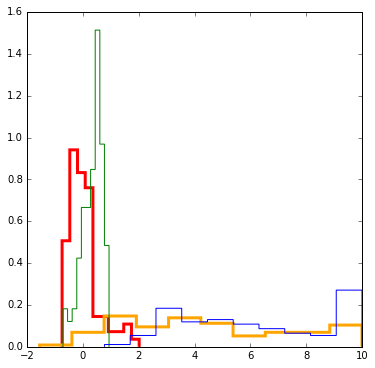

In [32]:
# comparing input layer, PCA, and ICA

feature_hist(nn100lin, histtype="step", color="red", normed=True, linewidth=3)
feature_hist(nn100nonlin, histtype="step", color="orange", linewidth=3, normed=True)

feature_hist(pca.transform(images), histtype="step", color="green", normed=True)
feature_hist(ica.transform(images), histtype="step", color="blue", normed=True)

![summary](sicon.png)

The linear input layer generates distributions that are close to PCA distributions of non-Gaussianity.

After the non-linearity, we see non-Gaussian distributions in the neural network comparable to ICA.

# PCA/ICA Input + Sigmoid + Output Layer

![chapter](chapter.png)

Since the input layer is so similar to a PCA transform, what happens if we actually replace it with PCA?

Since PCA isn't necessary "shifted" the right way relative to the nonlinearity, we add a BatchNorm1d layer, which learns a scale and bias separately for each feature.

In [33]:
pca = decomposition.PCA(100)
pca.fit(images.reshape(len(images), -1))
cupca = torch.FloatTensor(pca.transform(images)).cuda()
cutest_pca = torch.FloatTensor(pca.transform(test_images)).cuda()

First, we explicitly transform the input images into PCA space.

In [34]:
k = len(pca.components_)

def make_model():
    return nn.Sequential(nn.BatchNorm1d(k),
                         nn.Sigmoid(),
                         nn.Linear(k, 10))

Next, we create a model that uses the PCA outputs as inputs. Since we don't know the absolute scale of the PCA components, we add a batch norm layer to linearly transform the activation of each component.

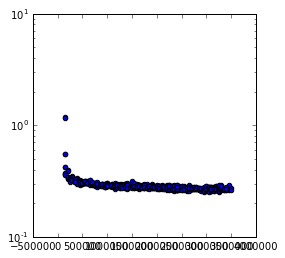

#best 0.0772 @ 2900000 of 3400000


Sequential(
  (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=10, bias=True)
)

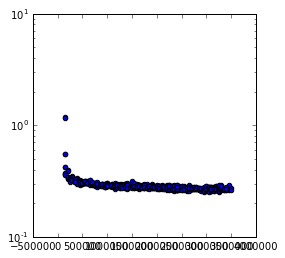

In [35]:
amlp = imgclass.AutoMLP(make_model, cupca, cuclasses, cutest_pca, cutest_classes,
                        initial_bs=500, maxtrain=5000000)
nnpca = amlp.train()
nnpca.cuda()

In [36]:
cuica = torch.FloatTensor(ica.transform(images)).cuda()
cutest_ica = torch.FloatTensor(ica.transform(test_images)).cuda()

Let's try the same with ICA.

In [37]:
k = len(ica.components_)

def make_model():
    return nn.Sequential(nn.BatchNorm1d(k),
                         nn.Sigmoid(),
                         nn.Linear(k, 10))

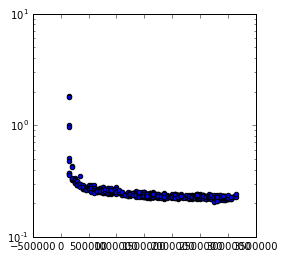

#best 0.0653 @ 3150000 of 3050000


Sequential(
  (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=10, bias=True)
)

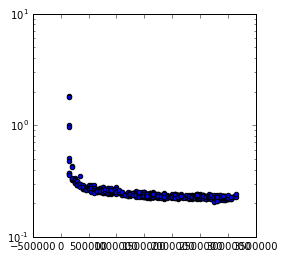

In [38]:
amlp = imgclass.AutoMLP(make_model, cuica, cuclasses, cutest_ica, cutest_classes,
                        initial_bs=500, maxtrain=5000000)
amlp.train()

![summary](sicon.png)

Replacing the linear input layer with a "pretrained" PCA/ICA layer results in substantially worse performance.

This is also a common kind of experiment when grafting different neural networks together (e.g., using different pretrained input layers).

# Irrelevant Features

![chapter](chapter.png)

Unsupervised: identify signal/noise by Gaussianity, magnitude.

Supervised: identify signal/noise from backpropagated deltas?


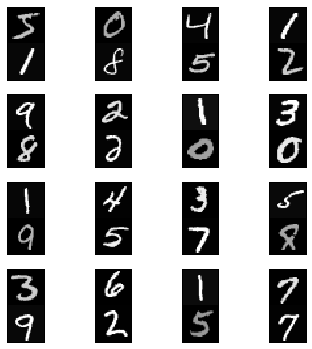

In [39]:
# Generate data with "noise": top half of image is relevant, bottom is not.

perm = range(60000); random.shuffle(perm)
pairs = hstack([images, images[perm,:]]).reshape(60000, 56*28)
cupairs = torch.FloatTensor(pairs).cuda()
perm = range(10000); random.shuffle(perm)
test_pairs = hstack([test_images, test_images[perm,:]]).reshape(10000, 56*28)
cutest_pairs = torch.FloatTensor(test_pairs).cuda()
showgrid(pairs.reshape(-1, 56, 28))

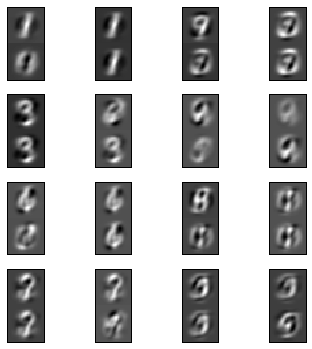

In [40]:
# PCA mixes up top and bottom characters because it tries to find an optimal code in the L2 sense

k = 100
pca = decomposition.PCA(k)
pca.fit(pairs.reshape(len(pairs), -1))
pca_basis = pca.inverse_transform(diag(ones(k))).reshape(k, 56, 28)
showgrid(pca_basis)

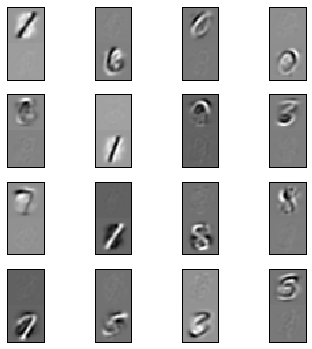

In [41]:
# ICA recognizes the top and bottom components as "independent causes"
# and represents them as separate dimensions in ICA space

k = 100
ica = decomposition.FastICA(k)
ica.fit(pairs.reshape(len(pairs), -1))
ica_basis = ica.inverse_transform(diag(ones(k))).reshape(k, 56, 28)
showgrid(ica_basis)

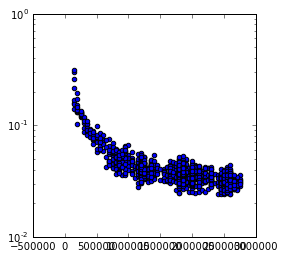

#best 0.0267 @ 2450000 of 2700000


Sequential(
  (0): Linear(in_features=1568, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=10, bias=True)
)

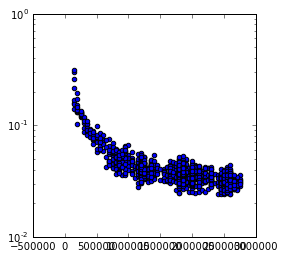

In [42]:
# train a network to perform classification

def make_model():
    return nn.Sequential(nn.Linear(56*28, 100), nn.Sigmoid(), nn.Linear(100, 10))

amlp = imgclass.AutoMLP(make_model, cupairs, cuclasses, cutest_pairs, cutest_classes,
                        initial_bs=20, maxtrain=10000000, decay=1e-5)
figsize(8, 8)
pnn100 = amlp.train()
pnn100.cuda()

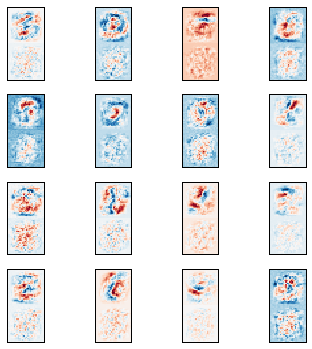

In [43]:
# display weights; note substantial non-zero weights in bottom half

W = N(pnn100[0].weight)
showgrid(W.reshape(100, 56, 28), cmap=cm.RdBu)

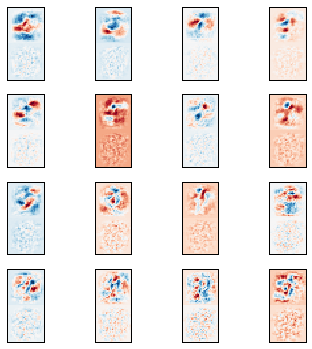

In [44]:
# weights are much larger at the top than at the bottom

pca = decomposition.PCA(20)
pca.fit(W.reshape(len(W), -1))
showgrid(pca.components_.reshape(-1, 56, 28), cmap=cm.RdBu)

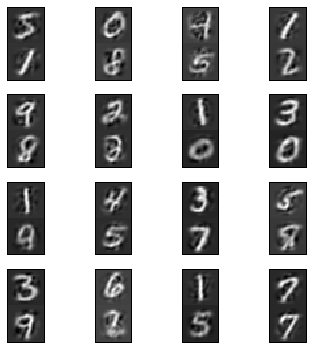

In [45]:
# nevertheless, we can still reconstruct the full inputs from the linear subspace

pnn100first_layer = N(pnn100[0](cupairs))
pnn100recon = dot(pnn100first_layer, dot(pinv(pnn100first_layer), cupairs))
showgrid(pnn100recon.reshape(-1, 56, 28))

# Why?

We are projecting a 784-dimensional space into 100-dimensional subspace.

Why is the information about the irrelevant features still recoverable after the linear projection?


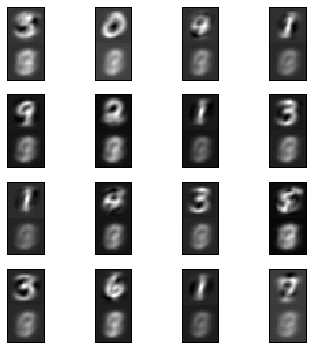

In [46]:
# after the nonlinearity, the information on the bottom half is largely destroyed,
# and the top half becomes harder to decode linearly

pnn100sig = N(nn.Sequential(*pnn100[:3])(cupairs))
pnn100sigrecon = dot(pnn100sig, dot(pinv(pnn100sig), cupairs))
showgrid(pnn100sigrecon.reshape(-1, 56, 28))

![summary](sicon.png)

Linear layers tend to have large weights for relevant features, small weights for irrelevant features.

Nevertheless, irrelevant information tends to be recoverable even after the linear layer.

It is the nonlinear layers that finally destroys the irrelevant information / noise.

# Summary

![chapter](chapter.png)

# Summary (Observations)

For fully connected layers with logistic hidden units:
- linear layers are PCA-like
- information is destroyed in the non-linear layer

# Summary (Techniques)

We have seen a number of useful experiments/tools:

- PCA, ICA, pseudo-inverse
- use measures of non-Gaussianity to determine whether layers aim for complete representation, non-Gaussianity, sparsity
- grafting together different networks
- techniques can be generalized by replacing linear methods with DNNs (at the cost of optimality)